# FaceGAN

Inspired by [this](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) tutorial.

Hello! In this notebook we'll train a GAN to generate images of faces. We'll set up the dataset, ... TODO fill in overview



In [2]:
%matplotlib inline

# Functions for training neural network
from tools import *
import torch
import torch.optim as optim
import os


# Functions for visualizations
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# from https://stackoverflow.com/questions/51512141/how-to-make-matplotlib-saved-gif-looping
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)


## Data

...instructions on how to download zip file, extract, and place under 'data' folder...

To train a GAN, we need to keep giving it examples of what real images should look like. Right now, we have a folder with all of these images. How do we go from images saved as files on our computer to images in number-form that are ready for a neural network to use?

Fortunately, the machine learning framework that we are using called PyTorch can do this for us. We've placed most of the PyTorch code for this in the file **tools/data.py**, but this is what it's doing behind the scenes:

1. Reads each image file into a list of numbers that specify the color at each pixel
2. Processes each image to the correct size and range of values
3. Creates a **data loader**, which keeps track of which images the GAN used already so it can keep giving it new ones in each round of training

The code below creates the data loader and plots some sample images.


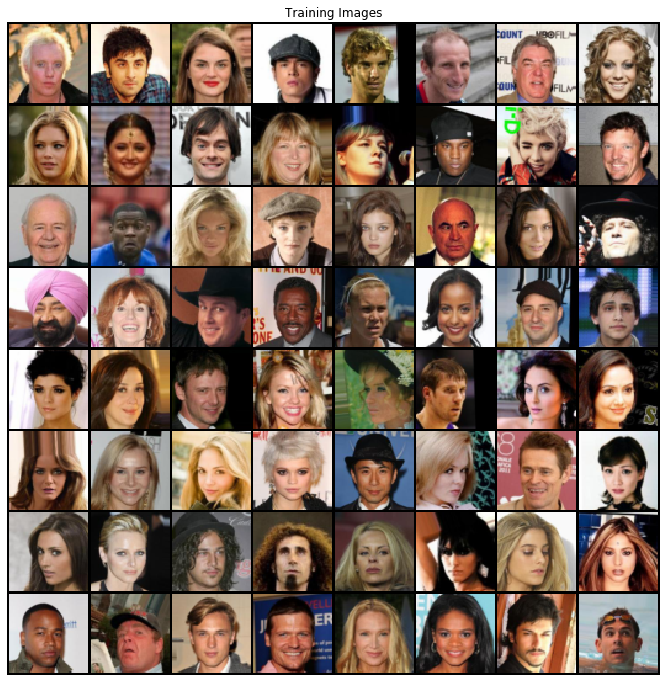

In [3]:
# Folder where images are stored
dataroot = "data/faces"

# Batch size: number of images the GAN sees in one round of training
batch_size = 128

# Size of images, in pixels (they will be square)
image_size = 64

dataloader = get_dataloader(dataroot, image_size, batch_size)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Input to the generator

Remember that the input to the generator model is just a random bunch of numbers.
Let's see what that looks like - it'll help you appreciate how difficult this problem is!

Note: The actual input is 1-dimensional - just a list of numbers. We'll create noise in the shape of a square just for visualization.

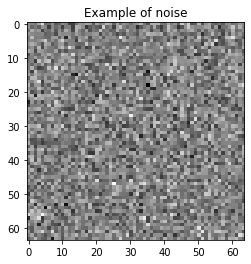

In [4]:

noise = torch.randn(64,64)
plt.imshow(noise, cmap='gray')
plt.title('Example of noise')
plt.show()

## Creating the models


Let's now create the generator and discriminator models.

In [5]:
# Size of noise vector (i.e. size of generator input)
noise_size = 100

# Use a GPU if available, or you can choose to use the CPU by setting use_cpu = True
use_cpu = False
device = 'cuda:7' if (torch.cuda.is_available() and not use_cpu) else 'cpu' # TODO change back to cuda:0
print('Using device {}\n'.format(device))


generator     = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

# Initialize the weights of the networks
generator.apply(initialize_weights)
discriminator.apply(initialize_weights)

# Print out the network structure
print('Generator structure:')
print(generator)
print('\n')

print('Discriminator structure:')
print(discriminator)

Using device cuda:7

Generator structure:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(

## Training the GAN


In [7]:
# Training settings
number_of_epochs = 30
learning_rate    = 0.0002


# Create optimizers, which are functions that will update the models for us
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
generator_optimizer     = optim.Adam(generator.parameters(),     lr=learning_rate, betas=(0.5, 0.999))

# Create batch of noise that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, noise_size, 1, 1, device=device)

# Create folder to save models in case training is interrupted
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)



In [ ]:
# Training Loop

# Lists to keep track of progress
sample_generator_images = []
G_losses = []
D_losses = []

# Keep track of discriminator performance
probs_real = []
probs_fake = []

iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(number_of_epochs):
    print('****** Starting epoch {} ******'.format(epoch))
    
    # For each batch in the dataloader
    for iteration, data in tqdm(enumerate(dataloader), total=len(dataloader)):
    
        # Parse data into the correct format for training
        real_images, labels_real, labels_fake, noise = format_data(data, device, noise_size)
        labels_real.fill_(0.9)
        labels_fake.fill_(0.1)
        
        ############################
        # (1) Update Discriminator
        ###########################
        discriminator.zero_grad()
        
        # Train discriminator on all-real batch
        predictions_on_real = discriminator(real_images)
        loss_on_real        = calculate_loss(predictions_on_real, labels_real)
        
        # Train discriminator on all-fake batch
        fake_images         = generator(noise)
        predictions_on_fake = discriminator(fake_images.detach())
        loss_on_fake        = calculate_loss(predictions_on_fake, labels_fake)
        
        # Update the discriminator model
        discriminator_loss = loss_on_real + loss_on_fake
        update(discriminator_optimizer, discriminator_loss)
        

        ############################
        # (2) Update Generator
        ###########################
        generator.zero_grad()
        
        # Try to fool discriminator into predicting that fake images are real
        predictions_on_fake = discriminator(fake_images)
        labels_real.fill_(1.0)
        generator_loss      = calculate_loss(predictions_on_fake, labels_real)
        update(generator_optimizer, generator_loss)

        # Output training stats every 100 iterations
        if iteration % 100 == 0:
            print('Iteration %d.\tLoss_D: %.4f\tLoss_G: %.4f\tProb real: %.4f\tProb fake: %.4f'
                  % (iteration,
                     discriminator_loss.item(),
                     generator_loss.item(),
                     predictions_on_real.mean().item(),
                     1 - predictions_on_fake.mean().item()))
            
        # Save Losses for plotting later
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())
        probs_real.append(predictions_on_real.mean().item())
        probs_fake.append(1 - predictions_on_fake.mean().item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == number_of_epochs-1) and (iteration == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            samples = vutils.make_grid(fake, padding=2, normalize=True)
            sample_generator_images.append(samples)
            
        iters += 1
        
        
    # Save models in case training is interrupted
    print('Saving models to {}'.format(save_dir))
    save_model(discriminator, discriminator_optimizer, epoch, os.path.join(save_dir, 'discriminator_epoch{}'.format(epoch)))
    save_model(generator,     generator_optimizer,     epoch, os.path.join(save_dir, 'generator_epoch{}'.format(epoch)))

    
    # Show some sample generated images after each epoch
    fig = plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(sample_generator_images[-1], (1,2,0)))
    plt.show()

In [ ]:
# Plot
fig = plt.figure(figsize=(15,15))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in sample_generator_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

ani.save('training_30epochs_with_smoothing.gif', writer=LoopingPillowWriter(fps=20))

HTML(ani.to_jshtml())

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator predictions on real and fake data")
plt.plot(probs_real,label="Probability that real is real")
plt.plot(probs_fake,label="Probability that fake is fake")
plt.xlabel("Iterations")
plt.ylabel("Probability")
plt.legend()
plt.show()